In [ ]:
!wget https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/master/utils.py
import utils
! pip install torch
! pip install gym
! pip install opencv-python
!pip install onnx onnxruntime
!pip install pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install xdpyinfo

--2021-04-29 17:51:11--  https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4519 (4.4K) [text/plain]
Saving to: ‘utils.py.6’

utils.py.6          100%[===================>]   4.41K  --.-KB/s    in 0s      

2021-04-29 17:51:11 (79.5 MB/s) - ‘utils.py.6’ saved [4519/4519]

ERROR: Could not find a version that satisfies the requirement xdpyinfo (from versions: none)
ERROR: No matching distribution found for xdpyinfo


In [ ]:
import time 
import numpy as np
from collections import deque, namedtuple
import collections
import os
import time
import shutil
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cv2
import gym
import gym.spaces

import matplotlib.pyplot as plt
import copy
%matplotlib inline
!nvcc --version

from matplotlib import animation
import seaborn as sns; sns.set()
from IPython.display import clear_output, HTML
from IPython import display
import torch.onnx

import pickle

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
from google.colab import drive
drive.mount("drive")
%cd drive/MyDrive/DQN

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
/content/drive/MyDrive/DQN


In [ ]:
USE_CUDA = torch.cuda.is_available()
Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
print(USE_CUDA)

device = "cuda" if torch.cuda.is_available() else "cpu"

True


In [ ]:
# DO NOT MAKE CHANGES HERE
from gym import spaces
import cv2
cv2.ocl.setUseOpenCL(False)

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255,
            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[0], shp[1], shp[2] * k), dtype=np.uint8)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=2)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

def make_atari(env_id):
    env = gym.make(env_id)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    return env

def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=True, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env



class ImageToPyTorch(gym.ObservationWrapper):
    """
    Image shape to num_channels x weight x height
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)
    

def wrap_pytorch(env):
    return ImageToPyTorch(env)

In [ ]:
# Replay buffer- stores a transitions - state, action, reward, next_state
# DQN network class - neural network - CNN -> linear layers
#                   - Add forward should give for a state and action pair, the expected return from t to T
# Fill_buffer function - add n samples to the replay buffer
# Train function - sample transitions and update network

In [ ]:
# TODO: Implement Prioritized Replay Buffer
# Code Block: (a)
class ReplayBuffer():
  def __init__(self, num_actions, memory_len = 10000):
      self.memory_len = memory_len
      self.transition = []
      self.num_actions = num_actions

  def add(self, state, action, reward, next_state, done):
      if self.length() > self.memory_len:
        self.remove()
      self.transition.append(Transition(state, action, reward, next_state, done))

  def sample_batch(self, batch_size = 32):
      minibatch = random.sample(self.transition, batch_size)

      states_mb, a_, reward_mb, next_states_mb, done_mb = map(np.array, zip(*minibatch))

      mb_reward = torch.from_numpy(reward_mb).to(device)
      mb_done = torch.from_numpy(done_mb.astype(int)).to(device)

      a_mb = np.zeros((a_.size, self.num_actions))
      a_mb[np.arange(a_.size), a_] = 1
      mb_a = torch.from_numpy(a_mb).to(device)

      return states_mb, mb_a, mb_reward, next_states_mb, mb_done

  def length(self):
      return len(self.transition)

  def remove(self):
      self.transition.pop(0)

In [ ]:
# Code Block: (b)
class DQNNetwork_atari(nn.Module):

    def __init__(self, num_actions = 4):
        super().__init__()
        # Define your architecture

        self.num_actions = num_actions
        # Network Architecture
        self.features = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1)
          )
          
        self.fc = nn.Sequential(
              nn.Linear(3136, 1500),
              nn.ReLU(True),
              nn.Linear(1500, 512),
              nn.ReLU(True),
              nn.Linear(512, self.num_actions)
          )

    def forward(self, x):
      # output forward should always be q values for all actions
        x = torch.tensor(x, dtype=torch.float).to(device)
        if len(x.size()) == 3:
          x = x.unsqueeze(dim=0)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x.double()

In [ ]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [ ]:
# Update Target network
# TODO: Complete this part for soft updating network for DQN
# Code Block: (h)
def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    """
    for l, t in zip(local_model.parameters(), target_model.parameters()):
      with torch.no_grad():
        t *= (1 - tau)
        t += tau * l 

In [ ]:
def set_seed(env, seed=None):
    if seed is not None:
        random.seed(seed)
        env.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

In [ ]:
# Code Block: (e) Hyperparameters
env_id = "PongNoFrameskip-v4"
num_episodes = 600 # number of episodes to run the algorithm
buffer_size = 10 ** 5 * 3 # size of the buffer to use
epsilon = 1.0 # initial probablity of selecting random action a, annealed over time
timesteps = 0 # counter for number of frames
minibatch_size = 128 # size of the minibatch sampled
gamma = 0.99 # discount factor
eval_episode = 100
num_eval = 10
tau = 1e-3 # hyperparameter for updating the target network
learning_rate = 0.00001 
update_after = 2000 # update after num time steps
epsilon_decay = 10**5
epsilon_ub = 1.0
epsilon_lb = 0.02

In [ ]:
# DO NOT MAKE CHANGES HERE
# Initialize environment
# Code Block: (c)
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)
num_actions = env.action_space.n
state_space = env.observation_space.shape

In [ ]:
# set seed
set_seed(env, 0)

In [ ]:
# Code Block: (b) 
dqn = DQNNetwork_atari(num_actions=num_actions).to(device)
dqn_target = DQNNetwork_atari(num_actions=num_actions).to(device)
# load saved weights, if you have already trained the model
anchor = 0
# dqn.load_state_dict(torch.load(f'checkpoint_save - {anchor}'))
# dqn_target.load_state_dict(torch.load(f'checkpoint_save - {anchor}'))
# losses = pickle.load(open(f"losses - {anchor}", "rb"))
# returns = pickle.load(open(f"returns - {anchor}", "rb"))
buffer = ReplayBuffer(num_actions=num_actions, memory_len=buffer_size)

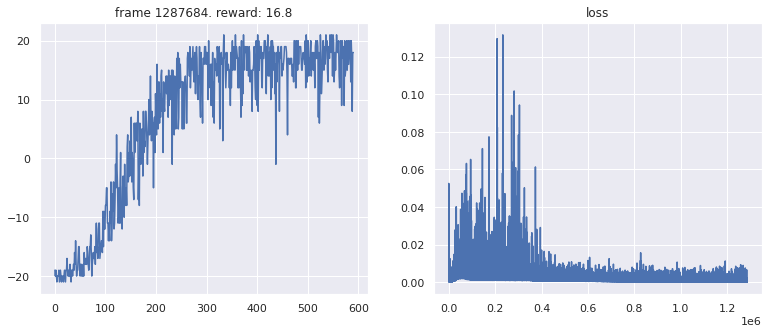

Episode:  591   20.0
Episode:  592   21.0
Episode:  593   14.0
Episode:  594   21.0
Episode:  595   18.0
Episode:  596   18.0
Episode:  597   21.0
Episode:  598   20.0
Episode:  599   16.0


In [ ]:
# Train the agent using DQN for Pong
returns = []
returns_50 = deque(maxlen=50)
losses = []
optimizer = optim.Adam(dqn.parameters(), lr=learning_rate)
mse = torch.nn.MSELoss()

state = env.reset()
timesteps = 0
for i in range(num_episodes):
  ret = 0
  done = False
  while not done:
    # Decay epsilon :
    epsilon = max(epsilon_lb, epsilon_ub - timesteps/ epsilon_decay)
    # action selection
    if np.random.choice([0,1], p=[1-epsilon,epsilon]) == 1:
      a = np.random.randint(low=0, high=num_actions, size=1)[0]
    else:
      net_out = dqn(state).detach().cpu().numpy()
      a = np.argmax(net_out)
    next_state, r, done, info = env.step(a)
    ret = ret + r
    # TODO: store transition in the replay buffer 
    # Code Block: (a)
    buffer.add(state, a, r, next_state, done)
    state = next_state
    timesteps = timesteps + 1

    # update policy using temporal difference
    if buffer.length() > minibatch_size and buffer.length() > update_after:
      optimizer.zero_grad()
      # TODO: Sample a minibatch randomly
      # Code Block: (a)
      states_mb, mb_a, mb_reward, next_states_mb, mb_done = buffer.sample_batch(minibatch_size)
      
      # TODO: Compute q values for states
      # Code Block: (g)
      q = dqn(states_mb)
      # TODO: compute the targets for training
      # Code Block: (g)
      target_q = dqn_target(next_states_mb)
      # TODO: compute the predictions for training
      # Code Block: (g)
      targets = torch.where(mb_done.byte(), mb_reward, mb_reward + gamma * torch.max(target_q, dim=-1).values)
      predictions = q[mb_a != 0]
      # Update loss: mse = mean squared error
      loss = mse(predictions, targets) 
      loss.backward(retain_graph=False)
      optimizer.step()
      losses.append(loss.item())
 
      # Update target network
      # Code Block: (h)
      soft_update(dqn, dqn_target, tau)
    if done:
      state = env.reset()
      print("Episode: ",i, " ",ret)
      break
  returns.append(ret)
  returns_50.append(ret)
  if i % 10 == 0:
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(returns_50)))
    plot(timesteps, returns, losses)
  if i % 100 == 0 and i != 0:
    pickle.dump(losses, open(f"losses - {i + anchor}", "wb"))
    pickle.dump(returns, open(f"returns - {i + anchor}", "wb"))
    torch.save(dqn.state_dict(), f'checkpoint_save - {i + anchor}') 

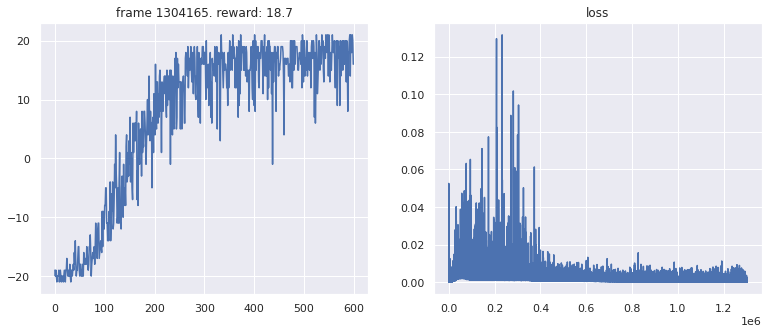

In [ ]:
plot(timesteps, returns, losses)

In [ ]:
# save model for reusing, not for submitting
torch.save(dqn.state_dict(), f'checkpoint_save - {i}')

In [ ]:
state = env.reset()

In [ ]:
# save model parameters for submitting solution using the following line of code
torch.onnx.export(dqn, # model
                  torch.tensor(state, dtype=torch.float), # example model input
                  'submission_onnx.onnx', # name of the submission
                  export_params=True, # save trained parameters
                  opset_version=10,
                  do_constant_folding=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
# test your onnx model using runtime - we are going to use this to test your model
# on the server.
import onnxruntime

ort_session = onnxruntime.InferenceSession('submission_onnx.onnx')

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(torch.tensor(state, dtype=torch.float))}
ort_outs = ort_session.run(None, ort_inputs)

In [ ]:
# check if output matches
ort_outs, dqn(state)

([array([[1.39930952, 1.42257619, 1.37839806, 1.38779044, 1.39195919,
          1.38726604]])],
 tensor([[1.4298, 1.4741, 1.4556, 1.4287, 1.4435, 1.4750]], device='cuda:0',
        dtype=torch.float64, grad_fn=<CopyBackwards>))

In [ ]:
# test on the env using onnx model
# We are going to use this block of code for testing your model on the server.
# Make sure your model works in this block of code, before submitting.
return_ = []
for i in range(50):
  state = env.reset()
  ret = 0
  done = False
  while not done:
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(torch.tensor(state, dtype=torch.float))}
    q_actions = ort_session.run(None, ort_inputs)
    action = np.argmax(q_actions)
    state, r, done, _ = env.step(action)
    ret += r
  return_.append(ret)

print("Average Return:", np.mean(return_))

Average Return: 19.76


In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(600, 400))
display.start()
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [ ]:
# Render env:
env.close()
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)
env = Monitor(env, './video', force=True)
state = env.reset()
done = False
while not done:
  env.render()
  ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(torch.tensor(state, dtype=torch.float))}
  q_actions = ort_session.run(None, ort_inputs)
  action = np.argmax(q_actions)
  state, r, done, _ = env.step(action)
  if done:
    state = env.reset()
show_video()